In [2]:
%matplotlib notebook

In [3]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [4]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [6]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [7]:
#GRID = Polygon([(1750,1600), (1750,2000), (2200, 2000), (2200, 1600)])
#GRID = Polygon([(1450,1800),(1450,2000),(2200,2000),(2200,1800)])

#GRID = [(1450, 1800), (2000, 2200)]
#GRID = [(1750, 1600), (2200, 2000)]

FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Entreno el modelo que vamos a usar para predecir

In [10]:
points_recep = sc.read.json('datos/train-test-by-emission.jsonlines/').rdd

In [11]:
normalizer = EmissionsNormalizer()
data = normalizer.normalize(points_recep)
regre_data, regre_target = normalizer.get_regression_dataframes(data)

In [12]:
predictor = KnnPredictor()
predictor.fit(regre_data, regre_target)

## Levanto el archivo con las emisiones de los pajaros

In [ ]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Me quedo solo con pajaros etiquetados

In [ ]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in MALES+FEMALES)

### Obtengo cual es el dia inicial en el que todos los pajaros tienen chip

In [ ]:
birds_recep_df = birds_recep.toDF()
birds_start_date = birds_recep_df.groupBy('tag_id').agg(F.min("timestamp"))
birds_start_date.agg(F.max('min(timestamp)')).collect()

In [ ]:
#start_date = '2018-01-03'
start_date = '2018-01-10' ## Fecha que me pasó Romina

### Obtengo cual es el dia final en el que todos los pajaros tienen chip

In [ ]:
birds_end_date = birds_recep_df.groupBy('tag_id').agg(F.max("timestamp"))
birds_end_date.agg(F.min('max(timestamp)')).collect()

In [ ]:
end_date = '2018-01-26'
#end_date = '2018-02-08'

### Filtro a partir de las fechas obtenida

In [ ]:
birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)

In [ ]:
birds_recep.count()

### Filtro en solo los horarios que nos interesa analizar y hago un checkpoint en disco

In [ ]:
START_TIME = '08:00:00'
END_TIME = '19:00:00'
birds_data_complete_df = birds_recep.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME).toDF()
birds_data_complete_df.write.parquet('tmp/checkpoint-cog.parquet')



### Levanto el chekpoint en pandas

In [8]:
birds_data_complete = pd.read_parquet('tmp/checkpoint-cog.parquet')
birds_data = birds_data_complete.drop(columns=['tag_id','timestamp'])

### Obtengo las predicciones

In [13]:
predictions = predictor.predict(birds_data)
predictions = pd.concat([pd.DataFrame(predictions), pd.DataFrame(birds_data_complete)], axis=1).values

### Aplico un suavizado a las predicciones

In [14]:
smoother = Smoother()
smooth_predictions = smoother.smooth_predictions(predictions)

### Aplico un filtro por suavizado a la predicciones

In [ ]:
smooth_filter_predictions = smoother.filter_predictions(predictions)

### Determino si uso las predicciones suavizadas o no

In [43]:
PREDICTION_TYPE = 'smooth'

In [44]:
if PREDICTION_TYPE == 'normal':
    final_predictions = smooth_predictions
elif PREDICTION_TYPE == 'smooth':
    final_predictions = predictions
elif PREDICTION_TYPE == 'smooth_filter':
    final_predictions = smooth_filter_predictions
else:
    raise Exception('PREDICTION_TYPE not defined')
    

### Calculo si la prediccion cayó dentro de la grilla

In [28]:
grid_predictions = []
for i in range(len(final_predictions)):
    prediction = final_predictions[i]
    point = Point(prediction[0], prediction[1])
    if GRID.contains(point):
        grid_pred = np.insert(prediction, 8,'in_grid', axis=0)
    else:
        grid_pred = np.insert(prediction, 8,'out_grid', axis=0)
    grid_predictions.append(grid_pred)

In [29]:
grid_predictions = pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'region'])


### Obtengo el tiempo en que cada posible pareja esta junta

In [40]:
def get_bird_timestamp_in_grid(bird_data):
    DELTA_TIME_IN_SEC = int((5 if PREDICTION_TYPE != 'smooth' else 5+smoother.step_size))
    timestamp_in_grid = []
    for row in bird_data['time']:
        real_time = datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        for i in range(-DELTA_TIME_IN_SEC, DELTA_TIME_IN_SEC+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append(datetime.strftime(res, '%Y-%m-%d %H:%M:%S'))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['time'])

male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions['region'] == 'in_grid')]

matches_per_bird = {}
for female_bird in FEMALES:
    female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions['region'] == 'in_grid')]
    timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid)
    
    male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index('time'), on='time', how='inner')

    female_matches = {}
    for index, row in male_in_grid_with_female.iterrows():
        tag = row['tag']
        current_matches = female_matches.get(tag, 0)
        female_matches[tag] = current_matches+1

    matches_per_bird[female_bird] = female_matches



### Imprimo matriz de confusion

In [ ]:
def show_confusion_matrices(matches_per_female):
    matrix_res = [[]] * len(FEMALES)
    for i in range(len(FEMALES)):
        matrix_res[i] = []
        for m in MALES:
            matrix_res[i].append(matches_per_bird.get(FEMALES[i]).get(m, 0))
         
    plt.figure()
    
    plt.subplot(3, 1, 1)
    plt.title('Birds matches')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g')
    ax.set(xlabel='Males', ylabel='Females')



    ### Esto muestra, para cada hembra, que porcentaje del tiempo que los otros machos estuvieron en la grilla 
    ### con cualquier hembra estuvieron juntos
    plt.subplot(3, 1, 2)
    plt.title('Male time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd/matrix_res_pd.sum()*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g')
    ax.set(xlabel='Males', ylabel='Females')


    ### Igual, pero con las hembras
    plt.subplot(3, 1, 3)
    plt.title('Female time distribution')
    matrix_res_pd = pd.DataFrame(matrix_res)
    matrix_res_pd.columns = MALES
    matrix_res_pd.rename(index={i:FEMALES[i] for i in range(len(FEMALES))}, inplace=True)
    matrix_res_pd = (matrix_res_pd.div(matrix_res_pd.sum(axis=1), axis=0)*100).round(2)
    matrix_res_pd = matrix_res_pd.fillna(0)
    ax = sn.heatmap(matrix_res_pd, annot=True, fmt='g')
    ax.set(xlabel='Males', ylabel='Females')



In [ ]:
show_confusion_matrices(matches_per_bird)

<IPython.core.display.Javascript object>


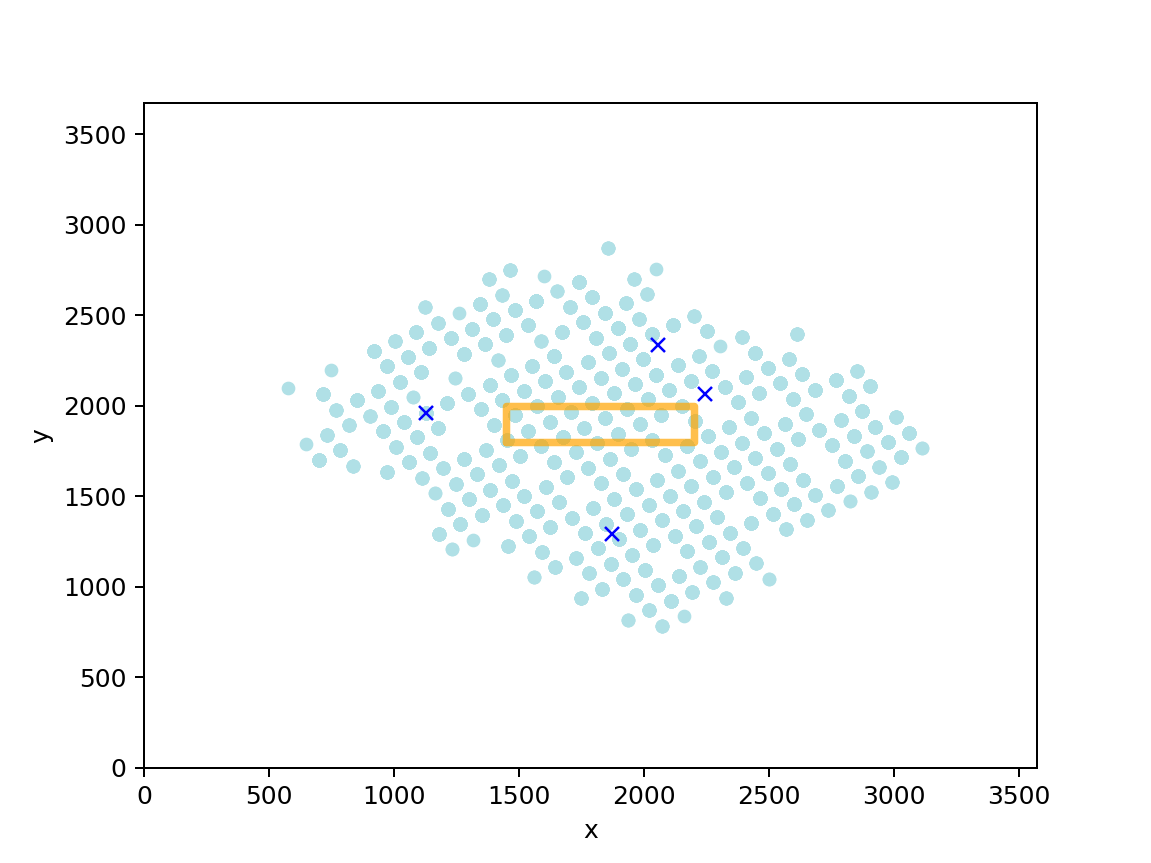

(0, 3572.611122813949)

In [105]:
x_f = 465958.114906211
y_f = 6112715.80637111
posicion_antenas = [(463512.015195402,6111004.324434620),(464259.981343845,6110331.85100085),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]

#points_sig = points_recep.groupBy(lambda x:x['Punto']).map(calculate_amount_antennas_recep).map(normalize_positions)
ax = pd.DataFrame(data.map(lambda x: {'x': x['x'], 'y':x['y']}).collect()).plot.scatter(x='x', y='y', c='#B0E0E6')

for i in range(4):
    pos_antena = posicion_antenas[i]
    ax.plot(pos_antena[0]-X_0, pos_antena[1]-Y_0, "xb")

x,y = GRID.exterior.xy
ax.plot(x, y, color='orange', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

plt.ylim(0,y_f-Y_0)
plt.xlim(0,x_f-X_0)

## Analizo coocurrencia en areas cercanas a las antenas

### Calculo si la prediccion fue cercana a alguna antena

In [45]:
antennas = []
for i in range(4):
    antennas.append({
        'pos': Point(ANTENNAS_POSITION[i]),
        'name': ANTENNAS_NAMES[i]
    })


grid_predictions = []
for i in range(len(final_predictions)):
    prediction = final_predictions[i]
    point = Point(prediction[0], prediction[1])
    
    close_to = None
    for antenna in antennas:
        if antenna['pos'].distance(point) < 200:
            close_to = antenna['name']
            
    grid_pred = np.insert(prediction, 8,close_to, axis=0)
    grid_predictions.append(grid_pred)

In [46]:
grid_predictions = pd.DataFrame(grid_predictions, columns=['x', 'y', 'recep_0', 'recep_1', 'recep_2', 'recep_3', 'tag', 'time', 'close_to'])


### Obtengo el tiempo que cada posible pareja estuvo junta

In [47]:
def get_bird_timestamp_in_grid(bird_data):
    DELTA_TIME_IN_SEC = int((5 if PREDICTION_TYPE != 'smooth' else 5+smoother.step_size))
    timestamp_in_grid = []
    for row in zip(bird_data.time, bird_data.close_to):
        real_time = datetime.strptime(row[0], '%Y-%m-%d %H:%M:%S')
        for i in range(-DELTA_TIME_IN_SEC, DELTA_TIME_IN_SEC+1):
            res=real_time+timedelta(seconds=i)
            timestamp_in_grid.append((row[1], datetime.strftime(res, '%Y-%m-%d %H:%M:%S')))

    timestamp_in_grid = list(set(timestamp_in_grid))
    return pd.DataFrame(timestamp_in_grid, columns=['close_to','time'])

male_birds_in_grid = grid_predictions[(grid_predictions.tag.isin(MALES)) & (grid_predictions.close_to.notnull())]

matches_per_bird_near_antenna = {}
for female_bird in FEMALES:
    female_bird_in_grid = grid_predictions[(grid_predictions['tag'] == female_bird) & (grid_predictions.close_to.notnull())]
    timestamp_in_grid_pd = get_bird_timestamp_in_grid(female_bird_in_grid)
    
    male_in_grid_with_female = male_birds_in_grid.join(timestamp_in_grid_pd.set_index(['close_to','time']), on=['close_to','time'], how='inner')

    female_matches = {}
    for index, row in male_in_grid_with_female.iterrows():
        tag = row['tag']
        current_matches = female_matches.get(tag, 0)
        female_matches[tag] = current_matches+1

    matches_per_bird_near_antenna[female_bird] = female_matches



### Imprimo matriz de confusion

<IPython.core.display.Javascript object>


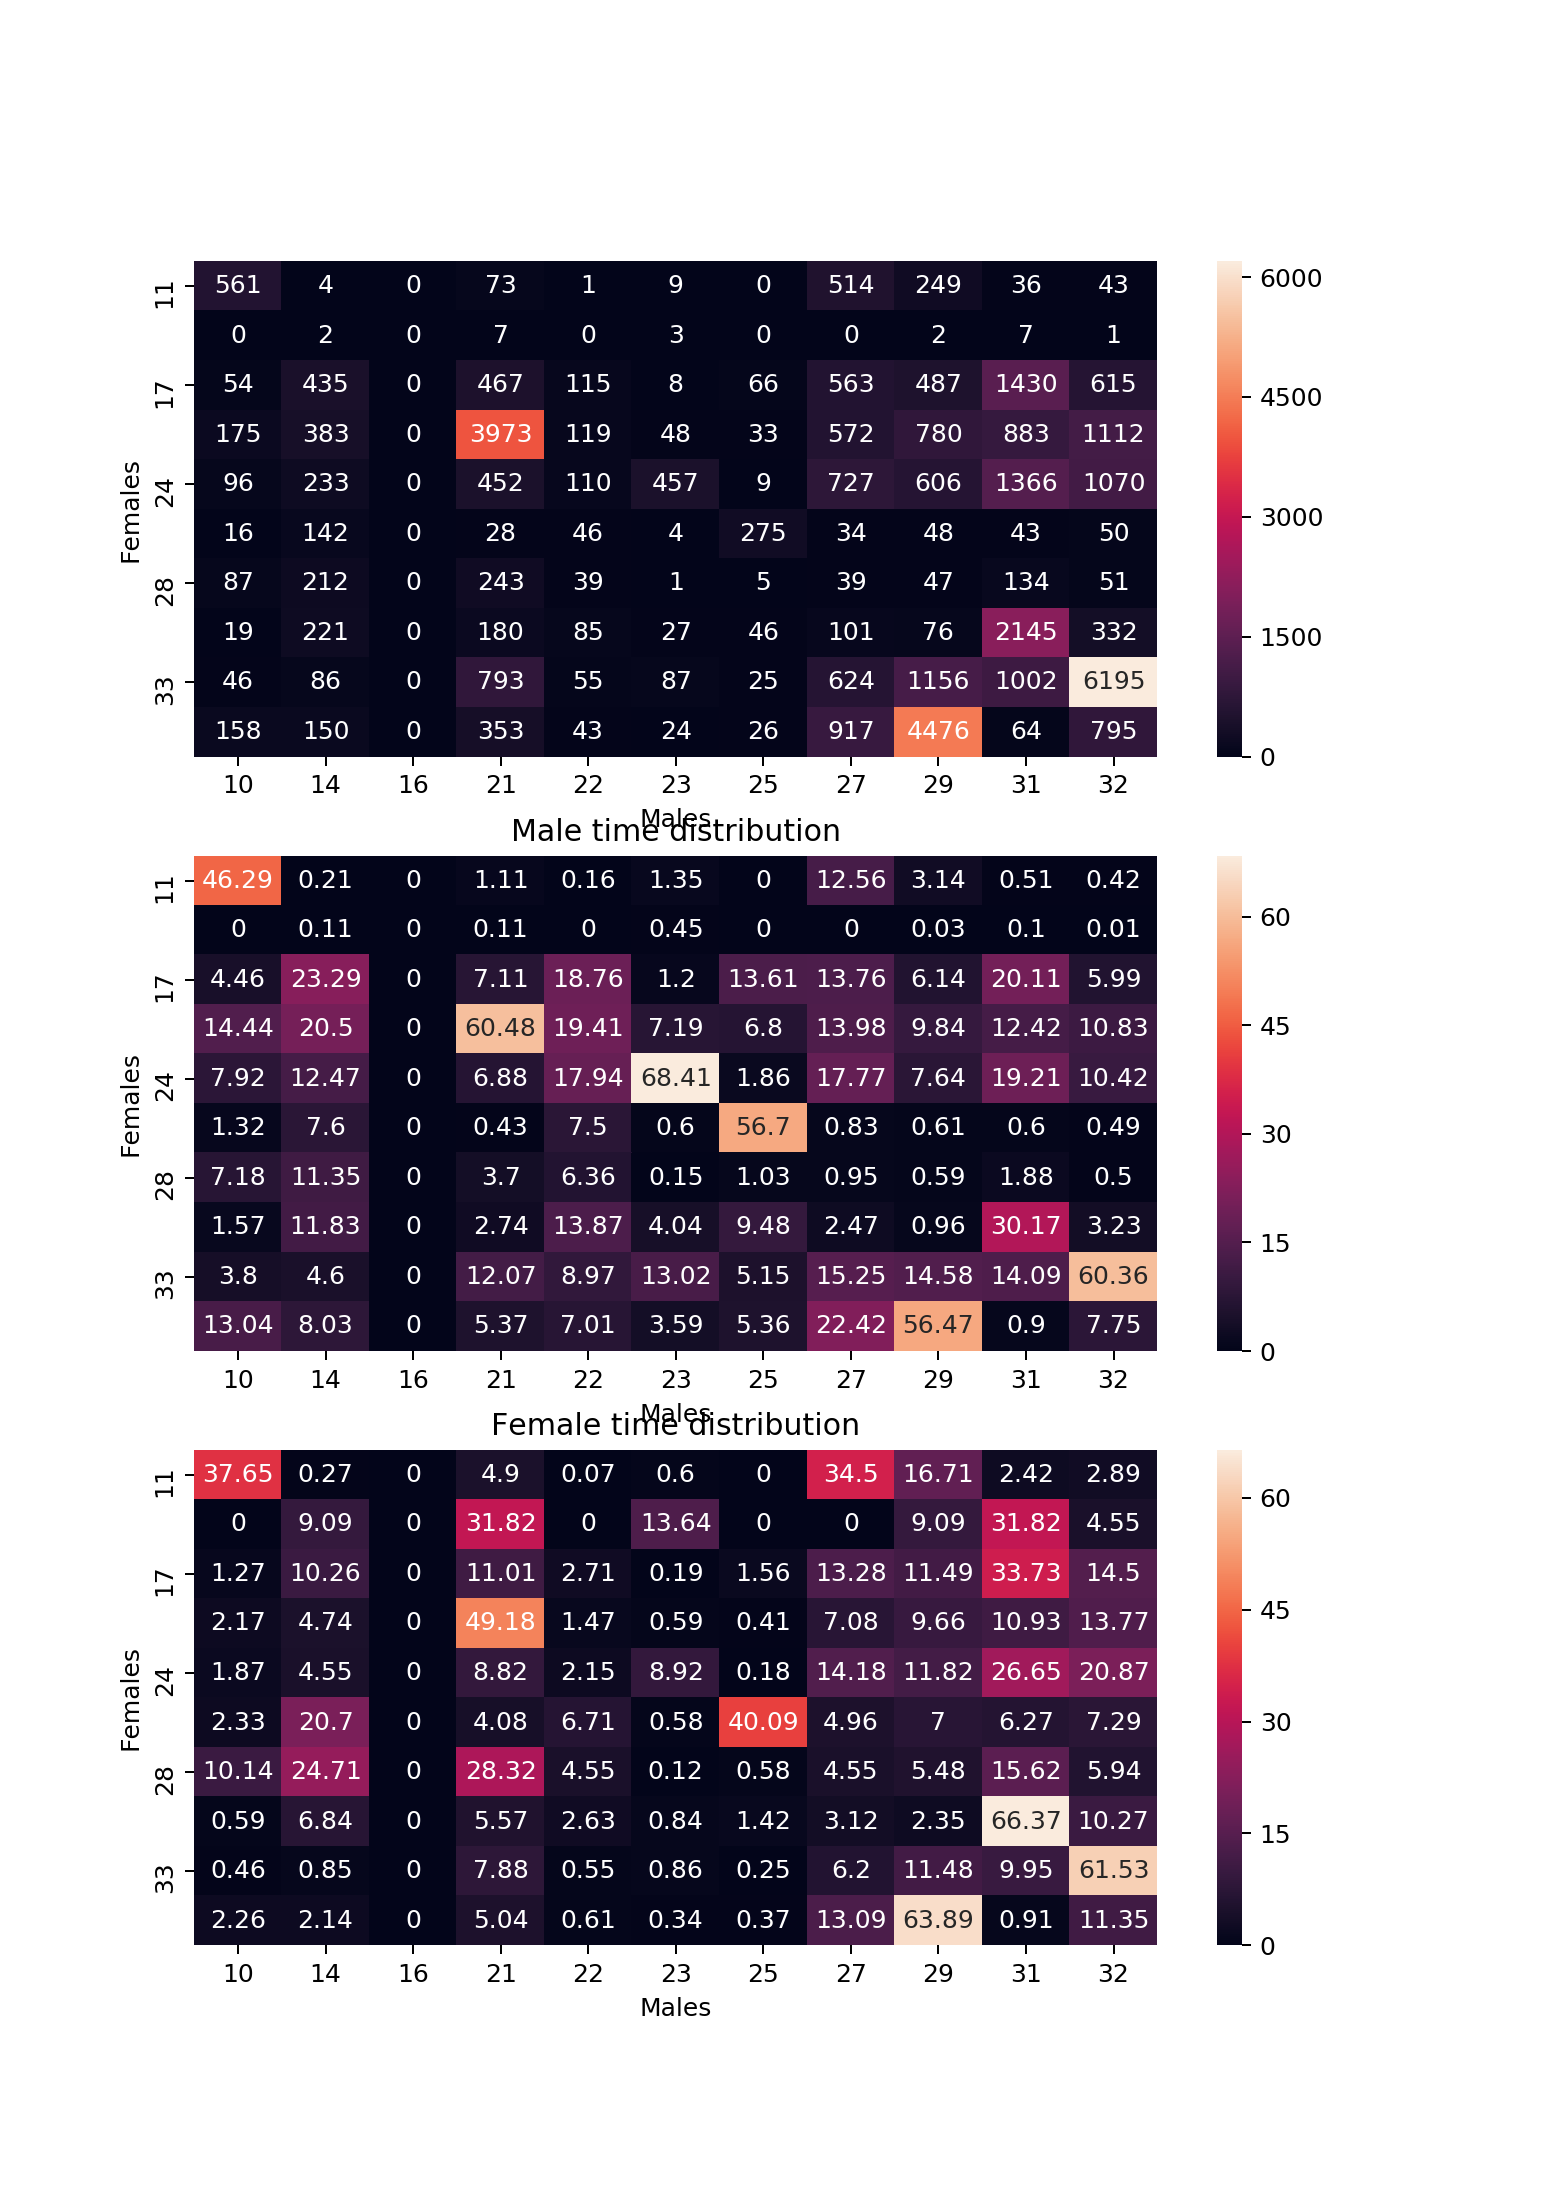

In [86]:
show_confusion_matrices(matches_per_bird_near_antenna)

In [ ]:
ax.se